# Imports

In [ ]:
pip install -q tensorflowjs

In [ ]:
import numpy as np 
import tensorflow as tf
import sklearn
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import PIL 

In [ ]:
import tensorflowjs as tfjs


# Set Hyperparameters:

Epochs

*   Epochs
*   INput Path
*   Output Path model
*   Output Path predictions
*   Path to segmentation model to load

In [ ]:
base_area_path = '/content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/data/area_weight'

# with this csv, honestly best thing is to just compare the segmentaion masks of same size
# hope it picks up on area/weight

csv_path = base_area_path + '/plant_area_data.csv'




# Data Preparation

In [ ]:
csv_df = pd.read_csv(csv_path)
print(csv_df.columns)
# only 80 rows, won't be able to get anything to meaningful here, but worth a try

# get rid of the 30th of december, paper says to ignore it
csv_df = csv_df[csv_df['harvest date'] != '30-Dec']


# honestly let's just count the number of pixels in the segmentaiton mask
# see the correlation matrix between that and the area, and the dry weight
csv_df[csv_df['barcode'] == 'AT20-0132a212'].values[0][5]

# drop anything where the date == 

Index(['tray', 'position', 'harvest date', 'barcode', 'fresh wt (mg)',
       'dry wt (mg)', 'rosette area (mm2)', 'comment'],
      dtype='object')


50

In [ ]:
full_grown = 'AT20-0134C514'

csv_df[csv_df['barcode'] == full_grown]


,tray,position,harvest date,barcode,fresh wt (mg),dry wt (mg),rosette area (mm2),comment


# Model Architecture

# Model Training

# 

# Load segmentation model


In [ ]:
# custom object


In [ ]:
# directories = tf.io.gfile.glob(save_checkpoints_minus_epoch + '/*/')
# directories = sorted(directories, key=lambda p: get_num_from_path(p))


In [ ]:
# loaded_model = tf.keras.models.load_model(directories[-1],  custom_objects={'MyMeanIOU': MyMeanIOU(2)})

In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [ ]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    """Return a filter mask with the top 1 predictions
    only.

    Parameters
    ----------
    pred_mask : tf.Tensor
        A [IMG_SIZE, IMG_SIZE, N_CLASS] tensor. For each pixel we have
        N_CLASS values (vector) which represents the probability of the pixel
        being these classes. Example: A pixel with the vector [0.0, 0.0, 1.0]
        has been predicted class 2 with a probability of 100%.

    Returns
    -------
    tf.Tensor
        A [IMG_SIZE, IMG_SIZE, 1] mask with top 1 predictions
        for each pixels.
    """
    # pred_mask -> [IMG_SIZE, SIZE, N_CLASS]
    # 1 prediction for each class but we want the highest score only
    # so we use argmax

    pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask

In [ ]:
@tf.function
def load_image_truth(datapoint: dict) -> tuple:
    """Normalize and resize a test image and its annotation.

    Notes
    -----
    Since this is for the test set, we don't need to apply
    any data augmentation technique.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_HEIGHT, IMG_WIDTH))
    input_area = datapoint['area']
    input_area = datapoint['weight']

    # input_image, input_mask = normalize(input_image, input_mask)

    input_image = tf.cast(input_image, tf.float32) / 255.0

    return input_image, input_area, input_weight

In [ ]:
def parse_image_truth(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """

    image = tf.io.read_file(img_path)
    # jpg in test instead
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    print(image.shape)


    # label_path = tf.strings.regex_replace(img_path, "rgb", "label")
    # mask = tf.io.read_file(mask_path)

    # # The masks contain a class index for each pixels
    # # TODO 
    # mask = tf.image.decode_png(mask, channels=0)
    print(img_path)

    row = csv_df[csv_df['barcode'] == full_grown].values
    print(row)

    return {'image': image, 'area': row[0][6], 'weight':row[0][4] }

In [ ]:
def get_area_weight(image_name):
  row = csv_df[csv_df['barcode'] == image_name].values
  return {'area': row[0][6], 'weight': row[0][4]}

In [ ]:
# parse_image_truth(truth_path)

(1898, 1876, 3)
/content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/data/area_weight/source_of_truth/AT20-0132c412_rosette.png
[]


IndexError: ignored

In [ ]:
@tf.function
def load_image_test(datapoint: dict) -> tuple:
    """Normalize and resize a test image and its annotation.

    Notes
    -----
    Since this is for the test set, we don't need to apply
    any data augmentation technique.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_HEIGHT, IMG_WIDTH))

    # input_image, input_mask = normalize(input_image, input_mask)

    input_image = tf.cast(input_image, tf.float32) / 255.0

    return input_image

In [ ]:
def parse_image_test(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """

    image = tf.io.read_file(img_path)
    # jpg in test instead
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    print(image.shape)


    # label_path = tf.strings.regex_replace(img_path, "rgb", "label")
    # mask = tf.io.read_file(mask_path)

    # # The masks contain a class index for each pixels
    # # TODO 
    # mask = tf.image.decode_png(mask, channels=0)
    return {'image': image}

In [ ]:
def displayPred(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
img = parse_image_test('/content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/data/area_weight/2016-01-05/AT20-0133c413_rosette.png')['image']

(4200, 2551, 3)


In [ ]:
img_normalized = load_image_test({'image': img, 'label': 1})
img_normalized.shape

TensorShape([128, 128, 3])

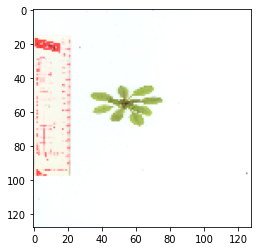

In [ ]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(img_normalized))

In [ ]:
# read in all the data with 2012 as images

path_to_glob = '/content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/data/segmentation/*2012*rgb.png'

In [ ]:
total_dataset = tf.data.Dataset.list_files(path_to_glob, seed=123)

In [ ]:
for path in total_dataset.take(10):
  print(path)

tf.Tensor(b'/content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/data/segmentation/ara2012_plant101_rgb.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/data/segmentation/ara2012_plant028_rgb.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/data/segmentation/ara2012_plant108_rgb.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/data/segmentation/ara2012_plant036_rgb.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/data/segmentation/ara2012_plant071_rgb.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/data/segmentation/ara2012_plant079_rgb.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/data/segmentation/ara2012_plant050_rgb.png', sh

In [ ]:
loaded_imgs = total_dataset.map(parse_image_test).map(load_image_test)

(None, None, 3)


In [ ]:
MAX_AREA = 8960

In [ ]:
for img in loaded_imgs.take(10):
  plt.imshow(tf.keras.preprocessing.image.array_to_img(img))
  output = loaded_model.predict(img[tf.newaxis, ...])
  mask = create_mask(output)
  
  displayPred([img, mask[0]])
  mask_area = tf.math.count_nonzero(mask)
  print(f'MASK AREA: {mask_area}. PCT: {mask_area / MAX_AREA}')
  

In [ ]:
## load the truth
truth_path = '/content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/data/area_weight/source_of_truth/AT20-0132c412_rosette.png'

(None, None, 3)
{'area': 1105.0, 'weight': 40.0}


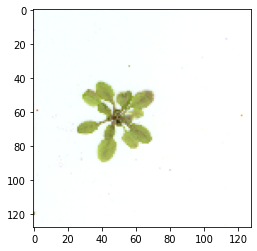

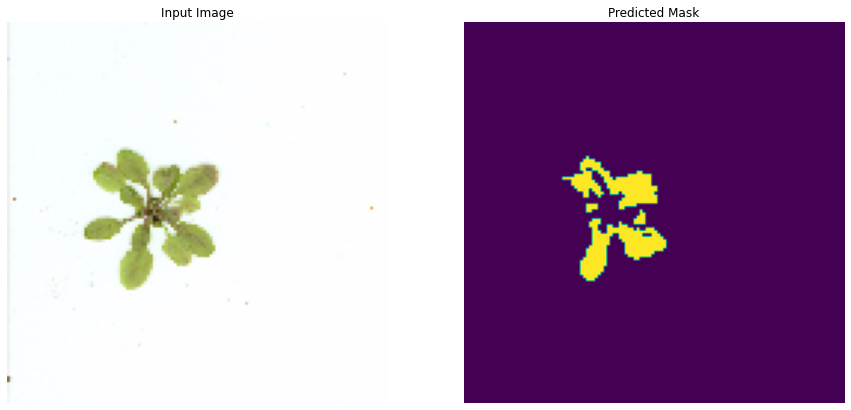

tf.Tensor(525, shape=(), dtype=int64)


In [ ]:
truth_img = tf.data.Dataset.list_files(truth_path, seed=123).map(parse_image_test).map(load_image_test)

for img in truth_img.take(1):
  # 
  print(get_area_weight('AT20-0132c412'))
  plt.imshow(tf.keras.preprocessing.image.array_to_img(img))
  img = tf.image.adjust_contrast(img, 1.2)
  output = loaded_model.predict(img[tf.newaxis, ...])
  mask = create_mask(output)
  displayPred([img, mask[0]])
  mask_area = tf.math.count_nonzero(mask)
  print(mask_area)
  

In [ ]:
truth_path_large = '/content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/data/area_weight/source_of_truth/AT20-0134D414_rosette.png'
truth_tag_large = 'AT20-0134d414'
truth_img_large = tf.data.Dataset.list_files(truth_path_large, seed=123).map(parse_image_test).map(load_image_test)

(None, None, 3)


{'area': 8110.0, 'weight': 422.1}


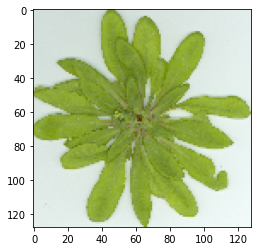

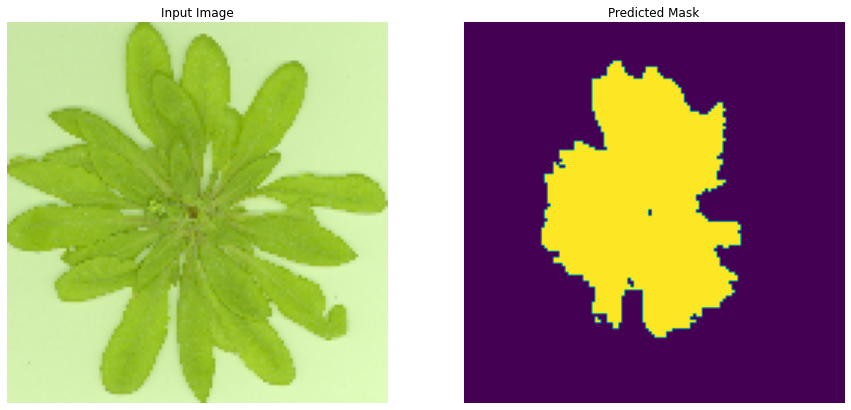

tf.Tensor(3984, shape=(), dtype=int64)


In [ ]:
for img in truth_img_large.take(1):
  # 
  print(get_area_weight(truth_tag_large))
  plt.imshow(tf.keras.preprocessing.image.array_to_img(img))
  img = tf.image.adjust_contrast(img, 0.4)
  output = loaded_model.predict(img[tf.newaxis, ...])
  mask = create_mask(output)
  displayPred([img, mask[0]])
  mask_area = tf.math.count_nonzero(mask)
  print(mask_area)


## only load the best one

In [ ]:
def get_num_from_path(p):
    try:
        last_slash = p.rfind('/')
        p = p[0:last_slash]
        second_slash = p.rfind('/')
        p = p[second_slash + 1:]
        return int(p)
    except:
        # p=0
        return 0


In [ ]:
save_checkpoint= '/content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/models/For_Area_Save_NoMeanIOU/{epoch}'

# '/{epoch}/'

In [ ]:
loaded_model = tf.keras.models.load_model(save_checkpoint)

# /content/drive/MyDrive/2021 Spring/Senior Design + IOT4Ag/IOT4Ag/models/For_Area_Save_NoMeanIOU/